# Chapitre 1 : Import  libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
df_train=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/train.csv')
df_test=pd.read_csv('/Users/abdul/Desktop/machine learning/data/home-data-for-ml-course/spaceship-titanic/test.csv')

In [ ]:
print(df_train.shape)
print(df_test.shape)

(8693, 14)
(4277, 13)


The training data groups together 8693 individuals for  14 variables.
The validation data brings together 4277 individuals for 13 variables.

What we know about variables:
- PassgerID ==> form gggg_pp where the first part indicates in which group the individual is traveling and the second is the number in that group. We are told that people in a group are often from the same family.
- Cryosleep ==> people who said 'yes' are confined to their cabin.
- Cabin ==> form deck/num/side, where side can be P for port or S for starborad
- name ==> first name/last name form

# Chapitre 2 : EDA


In [3]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Numerical variable

In [4]:
# numerical columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

In [14]:
# Describe the numerical columns
df_train[numerical_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [50]:
(df_train['Transported'].value_counts()/df_train.shape[0])*100

Transported
True     50.362361
False    49.637639
Name: count, dtype: float64

We see that around 1/2 person has been transported in another dimension.

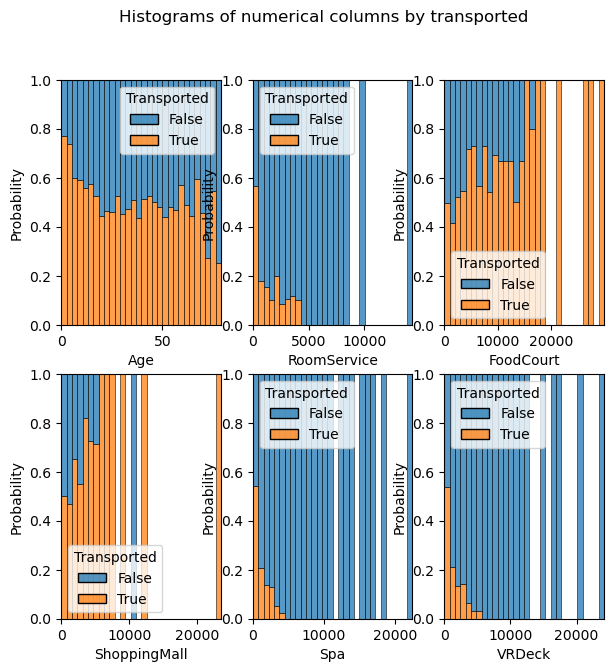

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(7, 7))
fig.suptitle('Histograms of numerical columns by transported')

# Flatten the axis array to access each subplot
ax = ax.flatten()
for i, col in enumerate(numerical_cols):
    sns.histplot(data=df_train, x=col, kde=False, color="skyblue", hue="Transported", multiple="fill", bins=30, stat='probability', ax=ax[i])
# Show the plot outside the loop
plt.show()

We see difference on the probability by 'Transported'. Let's see the missing value for the numerical variables.
- Young people (<30) have been more transported than other
- People with big bill in room service, spa and VRDeck have been less transported
- People with big foodcourt or shoppingmall have been more transported than other

In [5]:
data_num = df_train[numerical_cols]

In [6]:
# create a fonction for count missing values
def missing_values(x):
    missing_count= x.isnull().sum()
    percent_missing = (x.isna().sum()/x.shape[0])*100
    columns_with_missing_values= pd.DataFrame({'nom': missing_count.index,'Number missing':missing_count.values, 
                                               'percent missing':percent_missing.values})
    columns_with_missing_values=columns_with_missing_values[columns_with_missing_values['percent missing']>0]
    columns_with_missing_values=columns_with_missing_values.sort_values(by='percent missing',ascending=False)
    return columns_with_missing_values

In [7]:
missing_values(data_num)

,nom,Number missing,percent missing
3,ShoppingMall,208,2.392730
5,VRDeck,188,2.162660
2,FoodCourt,183,2.105142
4,Spa,183,2.105142
1,RoomService,181,2.082135
0,Age,179,2.059128


The percentage of missing value is arround 2%, it's acceptable so no need to remove variable. Simple imputation will work.

<Axes: >

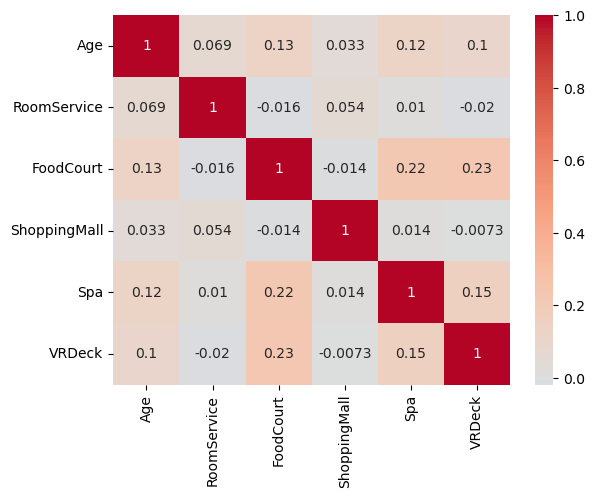

In [36]:
corr = data_num.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)

No big correlation between numerical variable

## Categorical variable

In [8]:
# categorical columns 
categorical_cols = df_train.select_dtypes(include=['object']).columns
categorical_cols

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name'],
      dtype='object')

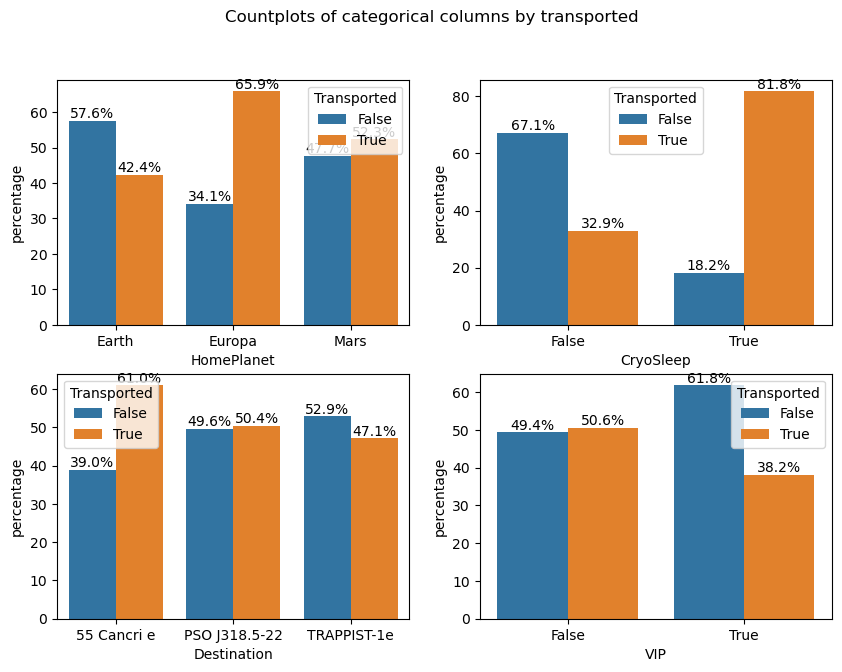

In [33]:
#split screen
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('Countplots of categorical columns by transported')
#select the variables to plot
vars = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
# loop to create the countplots
for i, var in enumerate(vars):
    counts = df_train.groupby(var)['Transported'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
    ax = sns.barplot(data=counts, x=var, y='percentage', hue='Transported', ax=axes[i//2, i%2])
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.show()

- People from Europa have been more transported (europa ++)
- Peapole in cryosleep have been more transported than other (81)
- People going to 55 cancrie have been more transported
- People with VIP ticket habe been less transported

# Chapter 3 : Pre-processing

objectif:
- create group thanks passenger ID
- Create groupe thans cabin variable
- Find family thanks name